In [1]:
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from scipy import stats
import seaborn as sns
import statsmodels.api as sm
import sys

import warnings
warnings.filterwarnings("ignore")
from statsmodels.formula.api import ols

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# read and write to config

In [2]:
CONFIG = "/wynton/home/ahituv/fongsl/EMF/config.ini"

config, cfn = crw.read(CONFIG)

DATE="20231222"
section = f"{DATE}_PEMF_HOb"
crw.check(config, section)

# read
DATA_PATH = config["local_path"]["data"]

# load
QPCR_PATH = os.path.join(DATA_PATH, "qpcr", section)
PLATE1="plate1.xls"
PLATE2="plate2.xls"


COMBINED = "qRT_PEMF.tsv"
LABELS = f"{DATE}_qPCR_labels.xlsx"

# write
config[section]["path"] = QPCR_PATH
config[section]["plate1"] = f"%(path)s/{PLATE1}"
config[section]["plate2"] = f"%(path)s/{PLATE2}"
config[section]["labels"] = f"%(path)s/{LABELS}"
config[section]["plate_combined"] = f"%(path)s/{COMBINED}"

crw.write(config, cfn)

RE = "/wynton/home/ahituv/fongsl/EMF/results/"
RE_DDCT = os.path.join(RE, f"{DATE}.ddCTs.tsv")

# go to datapath
os.chdir(QPCR_PATH)

# labels

In [3]:
sample=pd.read_excel(LABELS, sheet_name="sample")
sample = sample.rename(columns={"Sample":'sample_id',
                               "Sample_group":"sample_name", 
                               "Replicate_w": "rep", 
                               "Plate":"plate"
                              })
sample

,sample_id,sample_name,rep,plate
0,S1,Control,1,1
1,S2,Control,2,1
2,S3,Control,3,1
3,S4,PEMF-HF-physiostim l1,1,1
4,S5,PEMF-HF-physiostim l1,2,1
5,S6,PEMF-HF-physiostim l1,3,1
6,S7,PEMF-physiostim,1,1
7,S8,PEMF-physiostim,2,1
8,S9,PEMF-physiostim,3,1
9,S10,PEMF-HF-physiostim l3,1,1


## function

In [4]:
def plateToLongform(df, col_name):
    """transpose plate format into longform dataframe, name column"""
    transpose={}
    for n, row in df.iterrows():
        transpose[n] = row
    
    # make dataframe
    dfT = pd.DataFrame(pd.concat(transpose.values())).reset_index()

    # rename columns
    dfT.columns = ["col_pos", col_name]
    return dfT
    

In [5]:
def mergeDataFrames(df1, df2, col=None):
    """left merge two dataframes on index"""
    
    if col != None:
        merged = pd.merge(df1, df2, on=col)
    else:
        merged = pd.merge(df1, df2, left_index=True, right_index=True)
    return merged

In [ ]:
def plotDct(gene, df_, control_gene, date):
    if str(gene) != "empty" and str(gene) != "-":
        fig, ax = plt.subplots(figsize=(6, 6))
        data_ = df_.loc[(df_['sample_name'] != "noRT") &
                        (df_["primers"] == gene)
                        ].copy()

        plot = data_.groupby(["sample_name", "primers",  "rep", ])[
            "fold_change"].mean().reset_index()

       
        # stats
        statPS, pPS = stats.ttest_ind(data_.loc[data_["sample_name"] == "Control", "dCT"].to_list(),
                              data_.loc[data_["sample_name"] == "PEMF-physiostim", "dCT"].to_list())
        
        
        statHF, pHF= stats.ttest_ind(data_.loc[data_["sample_name"] == "Control", "dCT"].to_list(),
                              data_.loc[data_["sample_name"] == "PEMF-HF-physiostim l3", "dCT"].to_list())
        print("PEMF v. ctrl dCT", gene,pHF
              )
        print("PEMF-HF v. ctrl dCT", gene,pPS
              )
            
            
        x = "sample_name"
        y = 'fold_change'
        hue = "rep"
        data = plot
        order = [
            # 'Control',
            'PEMF-physiostim',
            'PEMF-HF-physiostim l3',
            'PEMF-HF-physiostim l1'
        ]
        sns.boxplot(data=data,
                    x=x, y=y,
                    order=order,
                    color="grey",

                    )

        sns.swarmplot(data=data, x=x, y=y,
                      hue=hue,
                      palette="Set2",
                      order=order,
                      alpha=0.8, size=10)

        ax.set(xlabel=f'60min PS p={"{:.2E}".format(pPS)}, HF l3 p={"{:.1E}".format(pHF)}',
               ylabel='Fold Change (2**-ddCT)',
               title=gene,
               ylim=(0.2, 4)

               )
        ax.axhline(1, ls="--", color="grey", alpha=0.2)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment="right")

        plt.legend(title='replicate', bbox_to_anchor=(1, 1), frameon=False)

        plt.savefig(os.path.join(
            RE, f"{date}_hs.{control_gene}.{gene}.pdf"), bbox_inches="tight")

        # Show the plot
        plt.show()

## primers

In [6]:
# assumes no header names
SHEETS = ["platemap1-primers", "platemap2-primers"]
primer_dict={}
for sheet in SHEETS:
    primers=pd.read_excel(LABELS, sheet_name=sheet,
                          header=None, names=np.arange(1,13))

    col_name="primers"
    primersT= plateToLongform(primers, col_name)
    
    # edit names
    primersT.loc[primersT["primers"]=="Hsp70c", 'primers'] = "HSP70C"
    primersT.loc[primersT["primers"]=="HSP70c", 'primers'] = "HSP70C"

    # add to dictionary
    primer_dict[sheet] = primersT

# drop the old index
primersT = pd.concat(primer_dict.values()).reset_index(drop=True)

## cdna

In [7]:
CDNAS = ["platemap1-cdna", "platemap2-cdna"]
cdna_dict={}
for sheet in CDNAS:

    cdna = pd.read_excel(LABELS, sheet_name=sheet, 
                         header=None, names=np.arange(1, 13))

    col_name = "sample_id"
    cdnaT = plateToLongform(cdna, col_name)
    
    # rename empty columns
    cdnaT.loc[cdnaT['sample_id']=="empty", 'sample_id'] = 'noRT'
    cdnaT.loc[cdnaT['sample_id'].isna(), 'sample_id'] = 'noRT'
    
    # add to dictionary
    cdna_dict[sheet] = cdnaT

cdnaT = pd.concat(cdna_dict.values()).reset_index(drop=True)

## results

In [8]:
ROWS = ["A", "B", "C", "D", "E", 'F', "G", "H"]

alphanum =[]
for letter in ROWS:
    for n in np.arange(1,13):
        alphanum.append(f"{letter}{n}")
        
# make df from columns
plate_map = pd.DataFrame(alphanum)

# rename the columns
plate_map.columns=["Well Position"]
plate_map

,Well Position
0,A1
1,A2
2,A3
3,A4
4,A5
...,...
91,H8
92,H9
93,H10
94,H11


In [9]:
PLATES = [PLATE1, PLATE2]
plate_dict = {}
for plate in PLATES:
    plate1 = pd.read_excel(plate, 
                           skiprows=40,
                           sheet_name="Results", 
                            usecols = ["Well Position", "CT"])

    # replace undetermined with None
    plate1.loc[plate1["CT"]=="Undetermined", "CT"] = None
    plate_ = pd.merge(plate_map, plate1, how="left")
    plate_["plate"] = plate
    plate_dict[plate]=plate_

plate1 = pd.concat(plate_dict.values()).reset_index(drop=True)

## merge

In [10]:
### primer information

df = mergeDataFrames(plate1, primersT)
df.tail(12)

,Well Position,CT,plate,col_pos,primers
180,H1,24.556337,plate2.xls,1,ACTB
181,H2,24.24918,plate2.xls,2,ACTB
182,H3,24.33288,plate2.xls,3,ACTB
183,H4,24.451042,plate2.xls,4,ACTB
184,H5,24.388071,plate2.xls,5,ACTB
185,H6,24.086273,plate2.xls,6,ACTB
186,H7,23.628096,plate2.xls,7,ACTB
187,H8,23.536882,plate2.xls,8,ACTB
188,H9,23.526117,plate2.xls,9,ACTB
189,H10,24.123596,plate2.xls,10,ACTB


In [11]:
### sample information

df = mergeDataFrames(df, cdnaT)

### sample name

df = pd.merge(df, sample, how="left", on="sample_id")
df["sample_name"] = df["sample_name"].fillna("noRT")
df.tail(12)

,Well Position,CT,plate_x,col_pos_x,primers,col_pos_y,sample_id,sample_name,rep,plate_y
180,H1,24.556337,plate2.xls,1,ACTB,1,S1,Control,1.0,1.0
181,H2,24.24918,plate2.xls,2,ACTB,2,S2,Control,2.0,1.0
182,H3,24.33288,plate2.xls,3,ACTB,3,S3,Control,3.0,1.0
183,H4,24.451042,plate2.xls,4,ACTB,4,S4,PEMF-HF-physiostim l1,1.0,1.0
184,H5,24.388071,plate2.xls,5,ACTB,5,S5,PEMF-HF-physiostim l1,2.0,1.0
185,H6,24.086273,plate2.xls,6,ACTB,6,S6,PEMF-HF-physiostim l1,3.0,1.0
186,H7,23.628096,plate2.xls,7,ACTB,7,S10,PEMF-HF-physiostim l3,1.0,1.0
187,H8,23.536882,plate2.xls,8,ACTB,8,S11,PEMF-HF-physiostim l3,2.0,1.0
188,H9,23.526117,plate2.xls,9,ACTB,9,S12,PEMF-HF-physiostim l3,3.0,1.0
189,H10,24.123596,plate2.xls,10,ACTB,10,S4,PEMF-HF-physiostim l1,1.0,1.0


# results 

## ct values

[Text(0, 0, 'noRT'),
 Text(1, 0, 'Control'),
 Text(2, 0, 'PEMF-physiostim'),
 Text(3, 0, 'PEMF-HF-physiostim l3'),
 Text(4, 0, 'PEMF-HF-physiostim l1')]

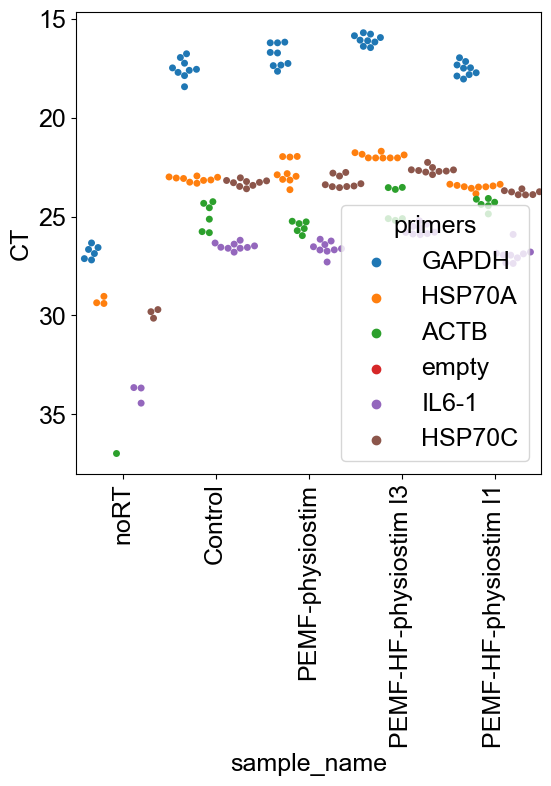

In [12]:
x="sample_name"
y="CT"
data=df#.loc[df["col_pos_x"].astype(int)!= 12]
hue="primers"
fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

## ANOVA

### columns

In [13]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(col_pos_x) + C(plate_x)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.319
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     6.683
Date:                Wed, 24 Jan 2024   Prob (F-statistic):           8.95e-10
Time:                        20:24:02   Log-Likelihood:                -474.33
No. Observations:                 184   AIC:                             974.7
Df Residuals:                     171   BIC:                             1016.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

### primers and samples

In [14]:
test = df.loc[df["CT"].astype(str)!="None"].copy()

# change datatypes
test[["col_pos_x", "primers", "sample_id"]] = test[["col_pos_x", "primers", "sample_id"]].astype(str) 

test["CT"] = test["CT"].astype(float)
test = sm.add_constant(test)

mod = ols("CT ~ C(primers) + C(sample_name)" , data=test)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     CT   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                     749.8
Date:                Wed, 24 Jan 2024   Prob (F-statistic):          4.32e-131
Time:                        20:24:07   Log-Likelihood:                -181.89
No. Observations:                 184   AIC:                             381.8
Df Residuals:                     175   BIC:                             410.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

## CT values

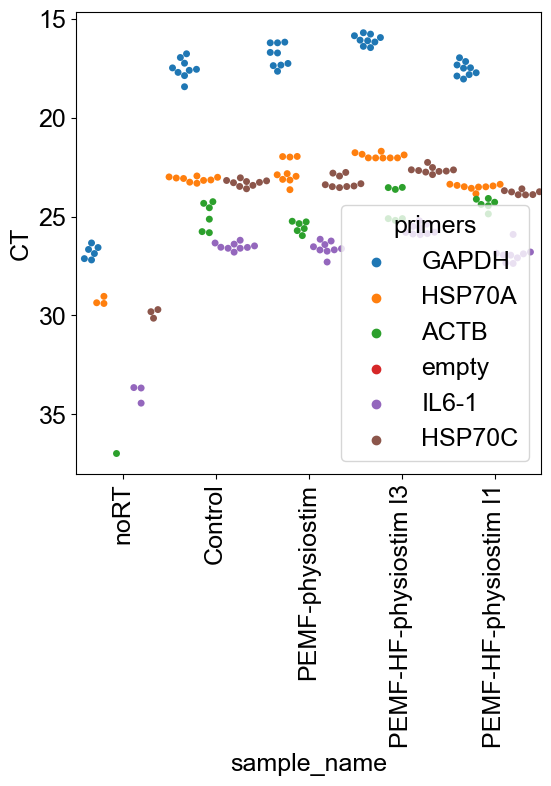

In [15]:
x="sample_name"
y="CT"
data=df#.loc[~df["col_pos_x"].isin([4, 12])]
hue="primers"

fig, ax=plt.subplots(figsize = (6,6))
sns.swarmplot(x=x, y=y, data=data, hue=hue, dodge=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.savefig(os.path.join(RE, f"{DATE}_CT_vals"), bbox_inches="tight")

<Axes: xlabel='col_pos_x', ylabel='CT'>

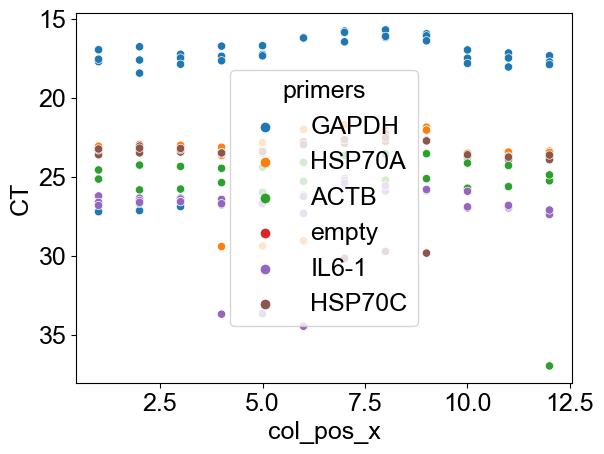

In [17]:
x="col_pos_x"
y="CT"
data=df
hue="primers"
sns.scatterplot(x=x, y=y, data=data, hue=hue)

<Axes: xlabel='col_pos_x', ylabel='CT'>

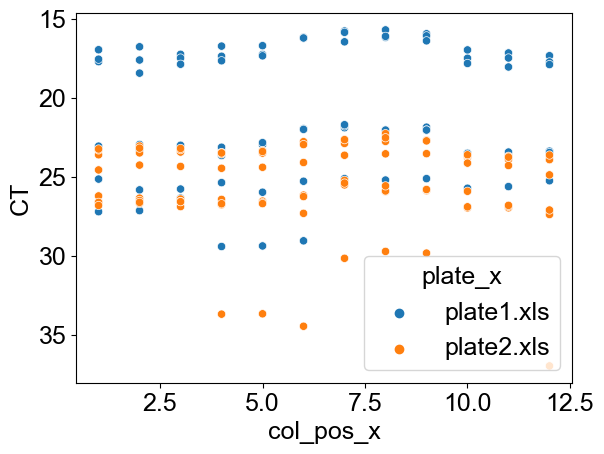

In [18]:
x="col_pos_x"
y="CT"
data=df
hue="plate_x"
sns.scatterplot(x=x, y=y, data=data, hue=hue)

In [19]:
def computeCT(df, control_gene):

    # mean ACTB CT per sample
    mean_ctrl = df[df['primers'] == control_gene].groupby('sample_name')['CT'].mean().reset_index()

    # rename columns
    mean_ctrl.rename(columns={'CT': 'Control_mean'}, inplace=True)

    # Merge mean ACTB values per sample
    test = pd.merge(df, mean_ctrl, on='sample_name', how='left')

    # dCT = obs CT - ACTB mean CT
    test['dCT'] = test['CT'] - test['Control_mean']

    # mean dCT per gene for control sample
    control_dCTs = test[test['sample_name'] == 'Control'].groupby(['primers'])['dCT'].mean().reset_index()  

    # rename columns
    control_dCTs.rename(columns={'dCT': 'Control_dCT_mean'}, inplace=True)

    # Merge control sample dCT values per gene
    test = pd.merge(test, control_dCTs, on='primers', how='left')
    test

    # ddCT = mean(dCT) sample - mean(dCT) control sample
    test['ddCT'] = test['dCT'] - test['Control_dCT_mean']

    # Assuming 'test' contains the 'ddCT' values for each gene

    # Calculate fold change using the formula 2^(-ddCT)
    test['fold_change'] = 2 ** (-test['ddCT'])
    
    return test

## compute ddCT with all datapoints

In [20]:
results = {}

## ACTB

PEMF v. ctrl dCT GAPDH 0.0003893390878571138
PEMF-HF v. ctrl dCT GAPDH 0.0001914246858797448


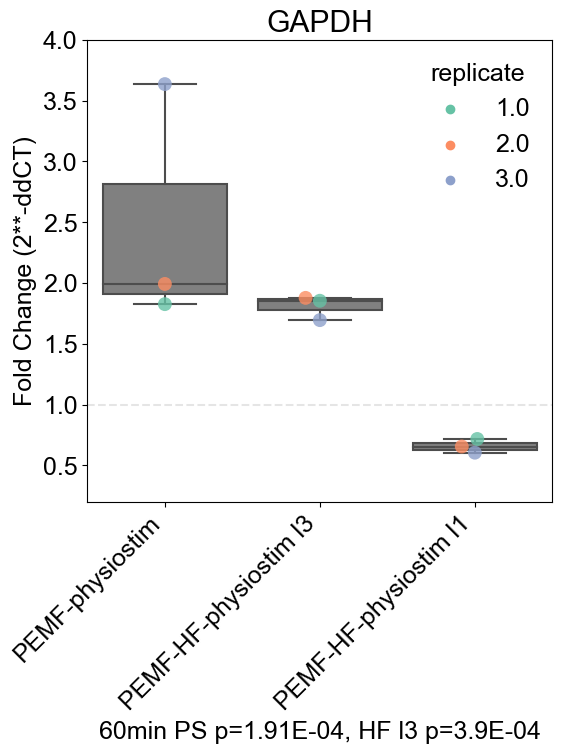

PEMF v. ctrl dCT HSP70A 1.0343581862314098e-07
PEMF-HF v. ctrl dCT HSP70A 0.0003563626076409576


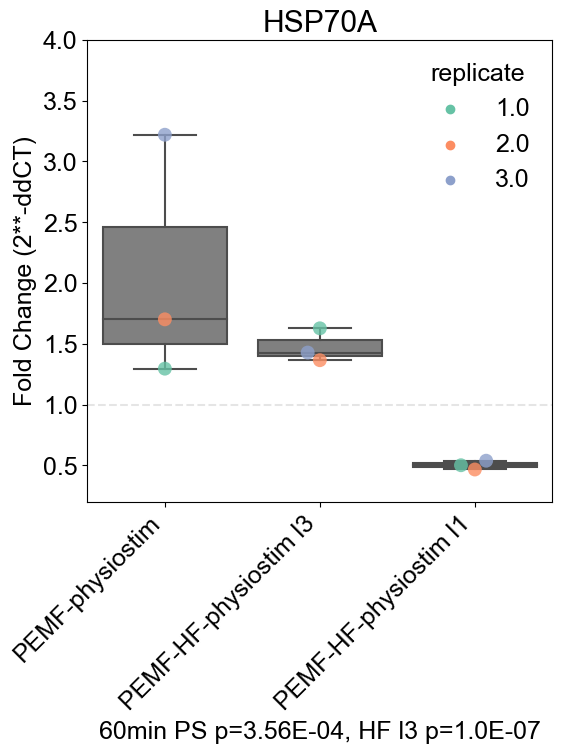

PEMF v. ctrl dCT ACTB 1.0
PEMF-HF v. ctrl dCT ACTB 1.0


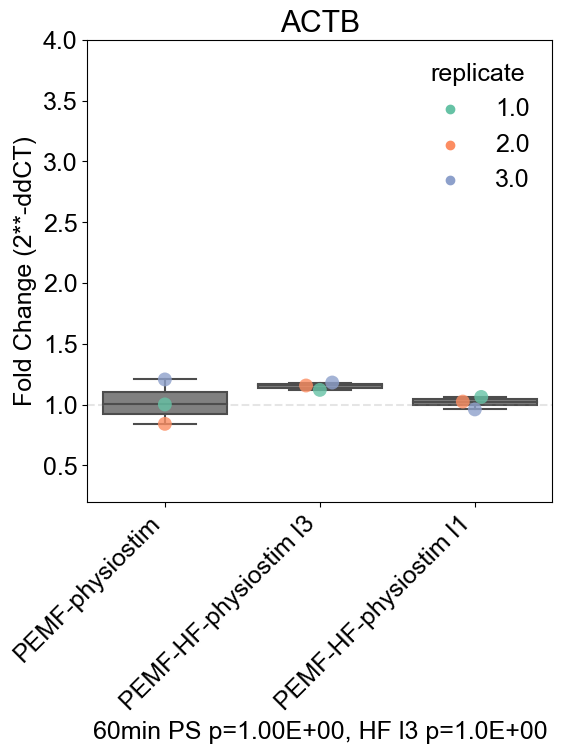

PEMF v. ctrl dCT IL6-1 0.04530863505542413
PEMF-HF v. ctrl dCT IL6-1 0.002304466622895986


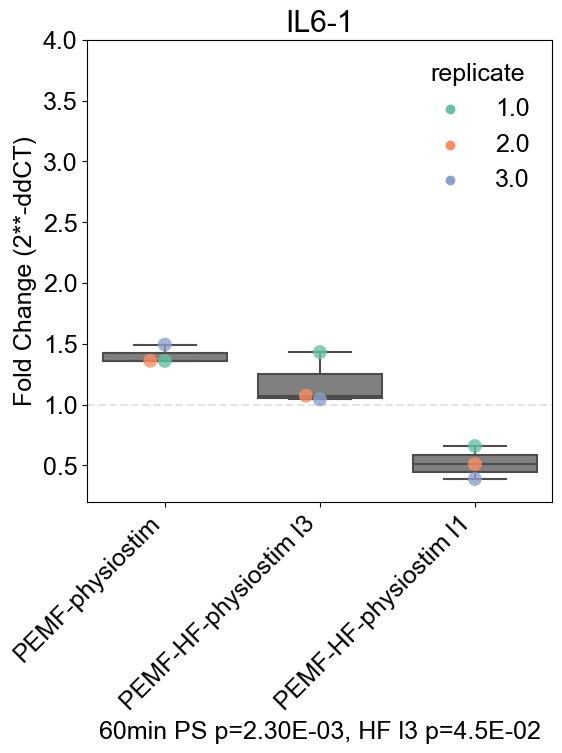

PEMF v. ctrl dCT HSP70C 0.6985674792107963
PEMF-HF v. ctrl dCT HSP70C 0.0001091156505457851


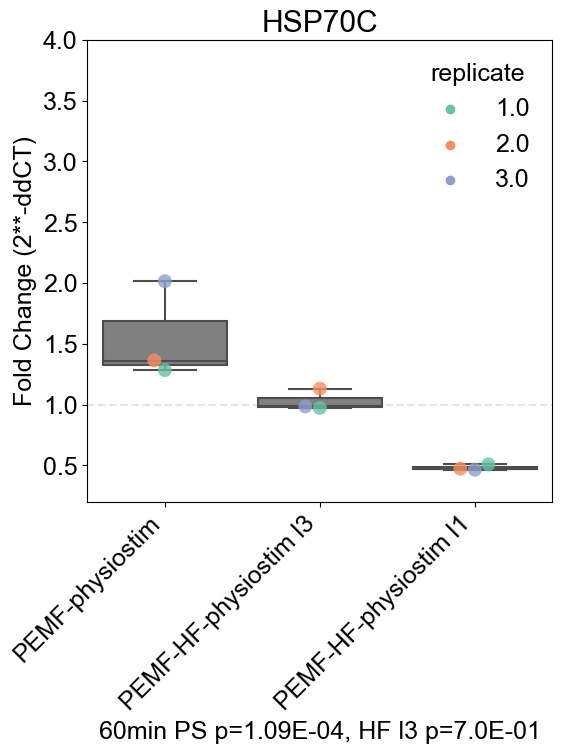

In [23]:
control_gene = 'ACTB'
df_ = computeCT(df, control_gene)
df_["control_gene"]=control_gene
results[control_gene] = df_

# Assuming 'df_' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn
for gene in set(df_['primers']):
    plotDct(gene, df_, control_gene, DATE)

## GAPDH

PEMF v. ctrl dCT GAPDH 0.9999999999999933
PEMF-HF v. ctrl dCT GAPDH 0.9999999999999976


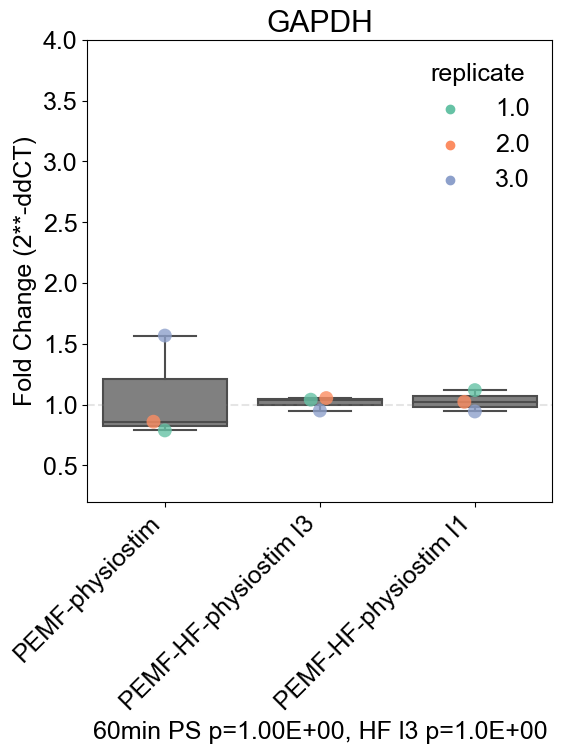

PEMF v. ctrl dCT HSP70A 0.0002890420282787063
PEMF-HF v. ctrl dCT HSP70A 0.1977114710059525


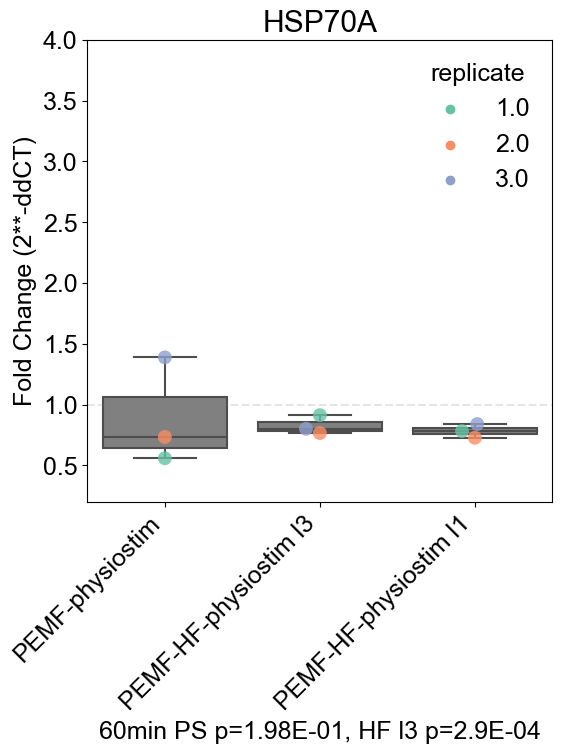

PEMF v. ctrl dCT ACTB 0.09605675905978468
PEMF-HF v. ctrl dCT ACTB 0.0028633052035115123


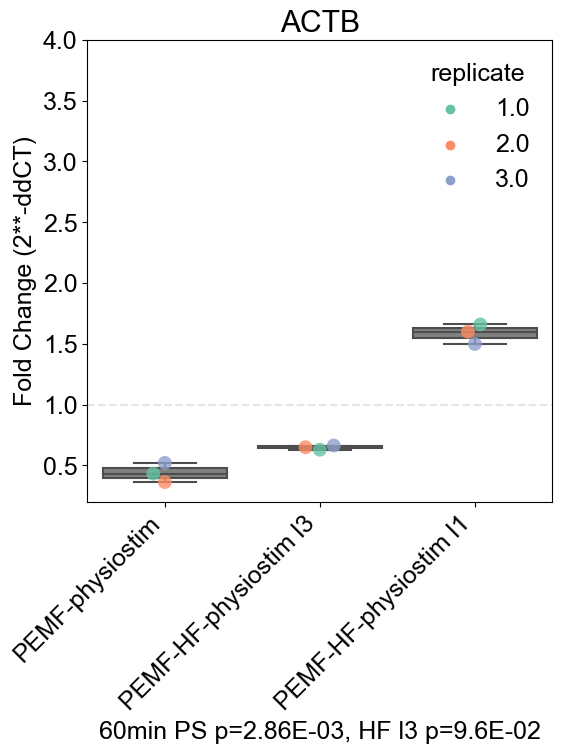

PEMF v. ctrl dCT IL6-1 1.8462987740743838e-05
PEMF-HF v. ctrl dCT IL6-1 1.8445720703011505e-05


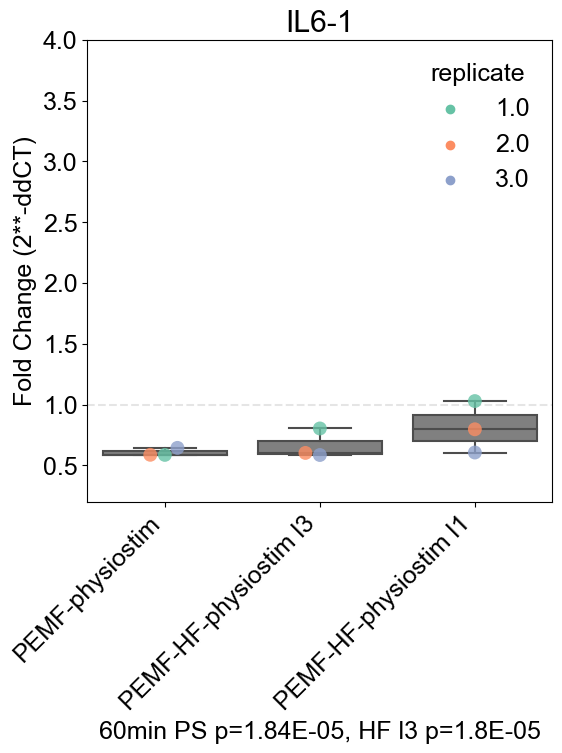

PEMF v. ctrl dCT HSP70C 3.038683823356727e-08
PEMF-HF v. ctrl dCT HSP70C 9.802502176116435e-05


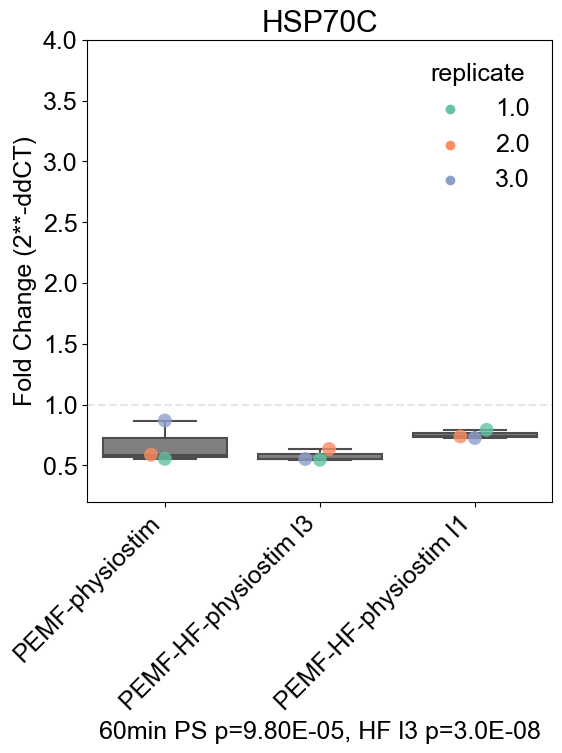

In [28]:
control_gene = 'GAPDH'
df_ = computeCT(df, control_gene)
df_["control_gene"]=control_gene
results[control_gene] = df_

# Assuming 'df_' contains the 'fold_change' values, and you want to create a boxplot with points

# Set up the boxplot and swarmplot using Seaborn

for gene in set(df_['primers']):
    plotDct(gene, df_, control_gene, DATE)

# write ddCT data 

In [30]:
write_cols = ['Well Position',
              'CT',
              'plate',
              'primers',
              'sample_name',
              'rep',
              'Experiment',
              'Control_mean',
              'dCT',
              'Control_dCT_mean',
              'ddCT',
              'fold_change',
              "control_gene",
              "date"]

In [36]:
re = pd.concat(results.values())
re.rename(columns={"plate_x": "plate"}, inplace=True)
re['Experiment'] = 2
re["date"] = DATE
re[write_cols].to_csv(RE_DDCT, sep='\t', index=False)

In [35]:
RE

'/wynton/home/ahituv/fongsl/EMF/results/'